# Generate reduced positive samples

Briefly:
1. Transform protein and RNA sequences into vectors using prot_BERT and rna2vec
2. Embed using optimized SAE
3. Concat vectors
3. Cluster using HDBSCAN
4. Sample n samples from each cluster to esablish data  

Headers:
1. Train hyperparameter optimized RNA and Protein SAEs
2. X

In [1]:
import sys
sys.path.append("..")

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import hdbscan;

from Utils.model_utils import DenseSAE
from Utils.model_datasets import SAEDataset
from Utils.train import SAETrainer, dense_sae_splitter
from Utils.encoders import SkipGramEmbedder, ProtBERTEmbedder

import torch

from fastai.basics import Learner, DataLoaders
from fastai.callback.all import *


from transformers import AutoTokenizer, AutoModel, pipeline
import sentencepiece

/home/bobby/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/bobby/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy

In [2]:
# Load sequence data
# Encode sequences
# Train SAE
# Embed RNA and protein data
# Concat vectors
# HDBSCAN 
# Sample 5k data from 

## Train hyperparameter optimized RNA and Protein SAEs

### Train hyperparameter optimized RNA2Vec SAE

In [3]:
def find_optimal_hyperparams_from_experiment(experimet_csv_path : str) -> dict:
    hyperparam_opt_results = pd.read_csv(experimet_csv_path, index_col = 0).dropna()
    min_loss               = min(hyperparam_opt_results['final_metric'])
    min_val_exp            = hyperparam_opt_results[ hyperparam_opt_results['final_metric'] == min_loss ].iloc[0,:]

    optimal_params = min_val_exp.to_dict()
    return optimal_params

In [4]:
rna_exp_csv = pd.read_csv("../nni/experiment_results/RNADenseSAE.csv", index_col = 0).sort_values("final_metric")
rna_exp_csv

,batchsize,hidden_layers,dropout,activation,final_metric
Bp2ga,64,[500],0.2,None,0.000404
ouBb8,64,[500],0.3,None,0.000535
dl8pb,128,[500],0.2,None,0.000549
E7DqE,128,[500],0.3,None,0.000676
gX67R,128,"[500,250]",0.2,None,0.001038
...,...,...,...,...,...
aZ2Hh,8,"[500,250]",0.5,nn.ReLU(),NaN
ljnAa,16,"[800,300,200]",0.4,nn.LeakyReLU(),NaN
WNMiD,32,"[800,600,400,200]",0.4,nn.ReLU(),NaN
aLMx4,32,[500],0.3,nn.LeakyReLU(),NaN


In [5]:
# Load model params
rna_exp_csv = "../nni/experiment_results/RNADenseSAE.csv"

rna_params = find_optimal_hyperparams_from_experiment(rna_exp_csv)

BATCHSIZE     = rna_params.pop("batchsize")
HIDDEN_LAYERS = eval(rna_params.pop("hidden_layers"))
ACTIVATION    = eval(rna_params.pop("activation"))
DROPOUT       = rna_params.pop("dropout")

In [6]:
# Initiate optimized model
rna_sae = DenseSAE(1024, hidden_layers = HIDDEN_LAYERS,
                   activation = ACTIVATION,
                   dropout = DROPOUT)

# Early stopping callback will cut off training when loss stabalizes
trainer = SAETrainer(9999, 255, plot = True)

In [2]:
pwd

'/data/Chapter_3/Notebooks'

epoch,train_loss,valid_loss,time
0,0.048093,0.003112,00:05
1,0.021075,0.001481,00:05
2,0.010237,0.001292,00:05
3,0.006522,0.001180,00:05
4,0.004954,0.000850,00:05
5,0.004504,0.000749,00:05
6,0.004381,0.000657,00:05
7,0.004270,0.000953,00:05
8,0.004201,0.000584,00:05
9,0.004224,0.000652,00:05


No improvement since epoch 25: early stopping


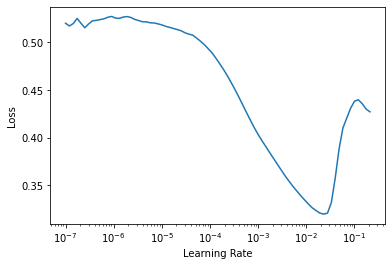

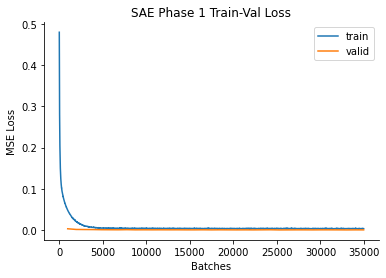

epoch,train_loss,valid_loss,time
0,0.003543,0.000652,00:05
1,0.003611,0.000507,00:05
2,0.003846,0.000689,00:05
3,0.003180,0.000619,00:05
4,0.003765,0.000708,00:05
5,0.003632,0.000485,00:05
6,0.003513,0.000888,00:05
7,0.003890,0.000518,00:05
8,0.003527,0.000774,00:05
9,0.003626,0.000930,00:05


No improvement since epoch 17: early stopping


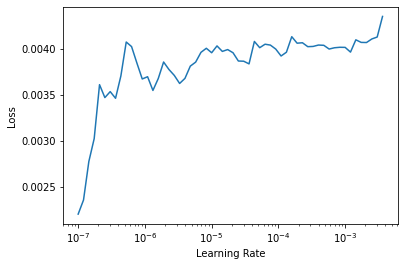

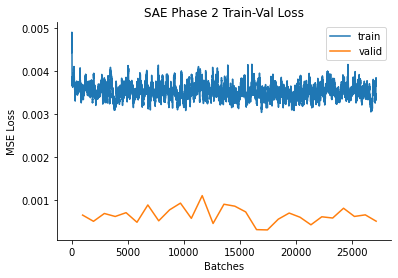

In [7]:
# Load and process data

if not os.path.exists("rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt"):
    rna_dense_embedded = torch.load("../Data/EncodedData/rnavec_encoded_aggregated_u_t_swapped_rnas.pt")

    train, val = train_test_split(np.array(rna_dense_embedded), random_state = 255)
    train = SAEDataset(torch.tensor(train))
    val   = SAEDataset(torch.tensor(val))

    # Initiate learner
    loaders = DataLoaders.from_dsets(train, val,
                                     bs=BATCHSIZE,
                                     device="cuda:0")

    ###################################################
    # Train SAE & find and record min loss
    ###################################################
    rna_dense_learner = trainer.train_sae(loaders, rna_sae, dense_sae_splitter,
                                          learner_cbs = [EarlyStoppingCallback(patience = 10)])
    
    torch.save(rna_dense_learner.model, "rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt")

### Train hyperparameter optimized ProtBERT SAE

In [8]:
# Load model params
prot_exp_csv = "../nni/experiment_results/ProtBERTDenseSAE.csv"
# d.sort_values('final_metric')

prot_params = find_optimal_hyperparams_from_experiment(prot_exp_csv)

# Best params with multiple layers
BATCHSIZE     = prot_params.pop("batchsize")
HIDDEN_LAYERS = eval(prot_params.pop("hidden_layers"))
ACTIVATION    = eval(prot_params.pop("activation"))
DROPOUT       = prot_params.pop("dropout")

In [9]:
# Initiate optimized model
prot_sae = DenseSAE(1024, hidden_layers = HIDDEN_LAYERS,
                    activation = ACTIVATION,
                    dropout = DROPOUT)

# Early stopping callback will cut off training when loss stabalizes
trainer = SAETrainer(9999, 255, plot = True)

epoch,train_loss,valid_loss,time
0,0.047636,0.003239,00:05
1,0.020272,0.001582,00:05
2,0.010302,0.001289,00:05
3,0.006302,0.000913,00:05
4,0.005295,0.000860,00:05
5,0.004486,0.000660,00:05
6,0.004158,0.000735,00:05
7,0.004274,0.000756,00:05
8,0.004433,0.000643,00:05
9,0.004247,0.000587,00:05


No improvement since epoch 37: early stopping


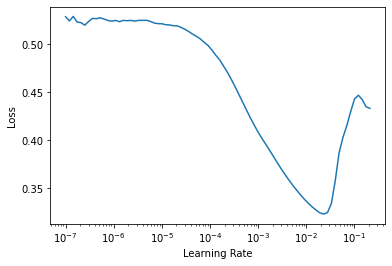

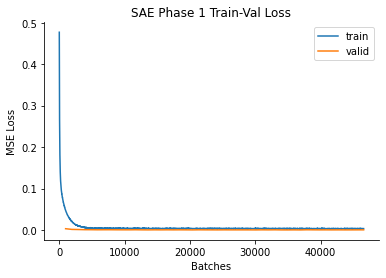

epoch,train_loss,valid_loss,time
0,0.003628,0.000465,00:05
1,0.003583,0.000374,00:05
2,0.003492,0.000605,00:05
3,0.003671,0.000393,00:05
4,0.003391,0.000351,00:05
5,0.003548,0.000410,00:05
6,0.003525,0.000366,00:05
7,0.003588,0.000457,00:06
8,0.003521,0.000379,00:06
9,0.003433,0.000362,00:06


No improvement since epoch 4: early stopping


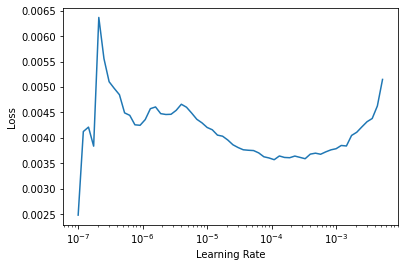

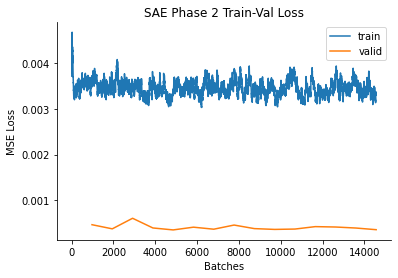

In [10]:
# Load and process data

if not os.path.exists("ProtBERT_encoded_110_swissprot_DenseSAE.pt"):

    prot_dense_embedded = torch.load("../Data/EncodedData/ProtBERT_encoded_110_swissprot.pt")

    train, val = train_test_split(np.array(prot_dense_embedded), random_state = 255)
    train = SAEDataset(torch.tensor(train))
    val   = SAEDataset(torch.tensor(val))

    # Initiate learner
    prot_loaders = DataLoaders.from_dsets(train, val,
                                          bs=BATCHSIZE,
                                          device="cuda:0")

    ###################################################
    # Train SAE & find and record min loss
    ###################################################
    prot_dense_learner = trainer.train_sae(loaders, prot_sae, dense_sae_splitter,
                                           learner_cbs = [EarlyStoppingCallback(patience = 10)])
    
    torch.save(prot_dense_learner.model, "ProtBERT_encoded_110_swissprot_DenseSAE.pt")

# Embed and concat sequences

In [11]:
from Utils.data_reduction import DataReducer

full_positive = pd.read_csv("../Data/TrainingData/PositiveSamples/RNAInter_small_interactions_current.csv")

In [12]:
full_positive['rnas'].apply(len).describe()

count    12161.000000
mean        37.411233
std         26.056531
min         16.000000
25%         22.000000
50%         22.000000
75%         62.000000
max        100.000000
Name: rnas, dtype: float64

In [13]:
full_positive['rnas'] = full_positive['rnas'].str.replace("T","U").str.replace("t","u")
full_positive['proteins'] = full_positive['proteins'].apply(" ".join)

In [14]:
PROT_LEN_LIMIT = 110
# prot_encoder   = ProtBERTEmbedder(PROT_LEN_LIMIT+2, cuda = True)
rna_encoder    = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True)

In [15]:
encoded_rnas = rna_encoder(full_positive['rnas'])

../Utils/encoders.py:241: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  kmer_matrix = torch.stack([torch.from_numpy(self.bio2vec.wv[kmer.lower()]) for kmer in kmers]).T


In [16]:
encoded_rnas

tensor([[ 0.0594, -0.4377,  0.0526,  ...,  0.2972,  0.2020,  0.4808],
        [ 0.1034, -0.4655,  0.0420,  ..., -0.1717,  0.1686,  0.0449],
        [ 0.2107, -0.7328,  0.2686,  ...,  0.2232, -0.0424,  0.7081],
        ...,
        [-0.2783, -0.4611, -0.4148,  ...,  0.2140,  0.2425,  0.1936],
        [ 0.2071, -0.2519,  0.5972,  ..., -0.2751, -0.0802, -0.1256],
        [-0.0286, -0.3779,  0.4139,  ..., -0.0795,  0.3838,  0.0880]])

In [17]:
from Utils.negative_sampling import IterableProteinEmbedding

In [18]:
chunksize = 2

tokenizer  = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)
model      = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

protein_iterator = IterableProteinEmbedding(full_positive['proteins'], tokenizer, model, chunksize, max_len = 110, cuda = True)
encoded_proteins = torch.cat([encoded_proteins for encoded_proteins in protein_iterator]).cpu()

In [19]:
prot_dense_learner.model(encoded_proteins.cuda())

tensor([[ 0.3535, -0.5568, -0.4282,  ..., -0.1077, -0.5357, -0.5210],
        [ 0.3535, -0.5568, -0.4282,  ..., -0.1077, -0.5357, -0.5210],
        [ 0.3535, -0.5568, -0.4282,  ..., -0.1077, -0.5357, -0.5210],
        ...,
        [ 0.3841, -0.3273, -0.6873,  ..., -0.2132,  0.6570, -0.9688],
        [ 0.2240, -0.3008, -0.3164,  ..., -0.5238, -0.5207, -0.7772],
        [ 0.2240, -0.3008, -0.3164,  ..., -0.5238, -0.5207, -0.7772]],
       device='cuda:0')

In [20]:
latent_proteins = prot_dense_learner.model(encoded_proteins.cuda()).cpu()
latent_rnas     = rna_dense_learner.model(encoded_rnas.cuda()).cpu()

latent_interactions = torch.cat([latent_proteins, latent_rnas], axis = 1)

In [21]:
latent_interactions.shape

torch.Size([12161, 1000])

In [22]:
class DataReducer:
    """
    Hyperparameter optimization and negative distribtuion sampling experiments
    require a reduced dataset to optimize the time needed to complete each
    expertiment. This is the inspiration behind DataReducer, which converts a
    list of sequences into their corresponding vectors, optionally reduces them 
    using a reducer function (e.g., SAE, t-SNE, UMAP transformations) and then 
    clusters them using a user defined cluster function. 
    """
    
    # Default fit -> transform clusterer arg
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    
    # Default reducer does nothing but return its input
    default_reducer = lambda x: x
    
    def __init__(self, embedder_fnc, cluster_fnc = clusterer.fit_predict, reducer_fnc = default_reducer, seed = 255):
        self.seed         = seed
        self.embedder_fnc = embedder_fnc
        self.cluster_fnc  = cluster_fnc
        self.reducer_fnc  = reducer_fnc
        
    def _transform_sequence_to_vec(self, sequences):
        return self.embedder_fnc(sequences)
    
    def _reduce_data(self, vectors):
        return self.reducer_fnc(vectors)
    
    def _fit_and_transform_vector_data(self, vectors):
        return self.cluster_fnc(vectors)
    
    def _isolate_data_by_cluster(self, data : np.array, clusters : np.array, cluster_id : int) -> np.array:
        return data[clusters == cluster_id,:]
    
    def _isolate_data_by_clusters(self, data : np.array, clusters : np.array) -> list:
        return [self._isolate_data_by_cluster(data, clusters, cluster) for cluster in set(clusters)]
    
    def _shuffle_array(self, array):
        np.random.seed(self.seed)
        np.random.shuffle(array)
        
    def _shuffle_clusterd_data_rows(self, isolated_data):
        
        for cluster in isolated_data:
            self._shuffle_array(cluster)
    
    def _merge_clustered_data(self, clusters):
        return np.concatenate(clusters)
    
    def _sample_reduced_data(self, n, vectors, cluster_idxs):
        CLUSTER_COUNT      = len(set(cluster_idxs))
        SAMPLE_PER_CLUSTER = ceil(n / CLUSTER_COUNT)
        
        print(f"TOTAL SAMPLES     : {n}")
        print(f"TOTAL CLUSTERS    : {CLUSTER_COUNT}")
        print(f"SAMPLE_PER_CLUSTER: {SAMPLE_PER_CLUSTER}")
        
        clusters     = self._isolate_data_by_clusters(vectors, cluster_idxs)
        samples      = [cluster[:SAMPLE_PER_CLUSTER] for cluster in clusters]
        sample_array = self._merge_clustered_data(samples)
        self._shuffle_array(sample_array)
        
        return sample_array
    
    #################################################################################
    def sample_reduced_data_from_encoded_seqs(self, n, vectors):
        # converts tensors, nested lists, and nested tuples to arrays
        vectors = np.array(vectors)
        
        reduced_vectors = self._reduce_data(vectors)
        clusters        = self._fit_and_transform_vector_data(reduced_vectors)
        samples         = self._sample_reduced_data(n, reduced_vectors, clusters)
        return samples
    
    def sample_reduced_data_from_sequences(self, n, sequences):
        print(f"Processing {len(sequences)} sequences...")
        vectors = self._transform_sequence_to_vec(sequences)
        samples = self.sample_reduced_data_from_encoded_seqs(n,vectors)
        return samples
    
    def load_and_filter_data_from_fasta(self, infile, alphabet, min_seq_len, max_seq_len, seq_limit):
        def comprised_of_proper_alpabet(sequence):
            "returns 'True' if sequence only contains letters of an alphabet"
            return not set(sequence).difference(alphabet)
        
        def is_eq_or_greater_than_min_len(sequence, min_seq_len):
            return len(sequence) >= min_seq_len
        
        def is_eq_or_less_than_max_len(sequence, min_seq_len):
            return len(sequence) <= max_seq_len
        
        def is_valid_sequence(sequence, min_seq_len):
            return is_eq_or_greater_than_min_len(sequence, min_seq_len) and \
                   is_eq_or_less_than_max_len(sequence, max_seq_len) and \
                   comprised_of_proper_alpabet(sequence)
        
        def shuffle_seq_list(sequences):
            random.seed(self.seed)
            random.shuffle(sequences)
        
        with open(infile) as handle:
            sequences = [str(record.seq) for record in SeqIO.parse(handle, 'fasta') if is_valid_sequence(str(record.seq), min_seq_len)]
            shuffle_seq_list(sequences)
            sequences = sequences[:seq_limit]
            return sequences
    
    def encode_data_from_fasta(self, infile, alphabet, min_seq_len, max_seq_len, seq_limit):
        sequences = self.load_and_filter_data_from_fasta(infile, alphabet, min_seq_len, max_seq_len, seq_limit)
        encoded_seqs = self._transform_sequence_to_vec(sequences)
        return encoded_seqs
    
    def sample_reduced_data_from_fasta(self, n, infile, alphabet, min_seq_len, max_seq_len, seq_limit):
        sequences = self.load_and_filter_data_from_fasta(infile, alphabet, min_seq_len, max_seq_len, seq_limit)
        samples = self.sample_reduced_data_from_sequences(n, sequences)
        return samples
                        
    ###############################################################
    def save_reduced_data_to_file(self, outfile, reduced_samples):
        "End extension should be .npy to save as numpy array or .pt to save as torch tensor"
        
        matrix_type = outfile.split('.')[-1]
        assert matrix_type in ['npy','pt'], f'outfile needs to have either an "npy" or "pt" extension for save as numpy array or pytorch tensor respectively. Got: {matrix_type}'
        
        if matrix_type == 'npy':
            with open(outfile, 'wb') as handle:
                np.save(outfile, reduced_samples)
                
        elif matrix_type == 'pt':
            torch_reduced_samples = torch.from_numpy(reduced_samples)
            torch.save(torch_reduced_samples, outfile)

In [23]:
import hdbscan
from Utils.data_reduction import DataReducer

# embedder_fnc, cluster_fnc = clusterer.fit_predict, reducer_fnc = default_reducer, seed = 255)

clusterer = hdbscan.HDBSCAN(min_cluster_size=4, random_state = 255)
TOTAL_SAMPLES = 5000

# empty_fnc = lambda x: x

# reducer = DataReducer(embedder_fnc = empty_fnc, cluster_fnc = clusterer.fit_predict, 
#                       reducer_fnc = empty_fnc, seed = 255)

# # sampled_interactions = reducer.sample_reduced_data_from_encoded_seqs(TOTAL_SAMPLES, latent_interactions)

In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4)
clusters  = clusterer.fit_predict(latent_interactions)

In [25]:
from math import ceil

CLUSTER_COUNT      = len(set(clusters))
SAMPLE_PER_CLUSTER = ceil(TOTAL_SAMPLES / CLUSTER_COUNT)

print(f"TOTAL SAMPLES     : {TOTAL_SAMPLES}")
print(f"TOTAL CLUSTERS    : {CLUSTER_COUNT}")
print(f"SAMPLE_PER_CLUSTER: {SAMPLE_PER_CLUSTER}")

TOTAL SAMPLES     : 5000
TOTAL CLUSTERS    : 1037
SAMPLE_PER_CLUSTER: 5


In [26]:
from Utils.misc import flatten

def return_cluster_idxs(clusters, cluster_id, sample_per_cluster):
    cluster_series = pd.Series(clusters)
    cluster_idxs   = cluster_series[cluster_series == cluster_id].index[:sample_per_cluster]
    return list(cluster_idxs)

def return_all_cluster_idxs(clusters, cluster_ids, sample_per_cluster):
    return flatten([return_cluster_idxs(clusters, cluster_id, sample_per_cluster) for cluster_id in cluster_ids])

In [27]:
cluster_idxs = return_all_cluster_idxs(clusters, set(clusters), SAMPLE_PER_CLUSTER)
print(f"total samples: {len(cluster_idxs)}")

total samples: 4939


In [28]:
reduced_positive_samples = full_positive.iloc[cluster_idxs,:]

# reduced_positive_samples.to_csv("../Data/TrainingData/PositiveSamples/reduced_RNAInter_small_interactions_current.csv", index = False)